In [8]:
# read list of nuclear charges, give energy predictions up to nth order

In [12]:
import numpy as np
import pandas as pd
import qml
import scipy.spatial as scs
import glob
import scipy.interpolate as sci
import functools
import matplotlib.pyplot as plt
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Code section

In [479]:
c = qml.Compound('../../test/c20.xyz')
def _get_nn(refsite):
    distances = np.linalg.norm(c.coordinates - c.coordinates[refsite], axis=1)
    return np.argsort(distances)[1:4]
def build_reindexing_1_merged(refsite, ontosite):
    cog = np.mean(c.coordinates, axis=0)
    valid = False
    for Ann in _get_nn(refsite):
        for Bnn in _get_nn(ontosite):
            A = c.coordinates[[refsite, Ann]]
            B = c.coordinates[[ontosite, Bnn]]
            rot = scs.transform.Rotation.match_vectors(A, B)[0]
            transformed = rot.apply(c.coordinates)
            found = []
            for site in range(len(c.coordinates)):
                ds = np.linalg.norm(transformed - c.coordinates[site], axis=1)
                if min(ds) < 1e-5:
                    found.append(np.argmin(ds))
            if set(found) == set([_ for _ in range(len(c.coordinates))]) and found[refsite] == ontosite:
                valid = True
                break
        if valid:
            break
    if not valid:
        raise ValueError('no solution')
    return found

def read_DENSITY(fn):
    with open(fn, 'r') as fh:
        _ = np.fromfile(fh, 'i4')
        q = _[3:-1].view(np.float64)
        ccdensity = q.reshape((-1, 10))
    ccdensity = ccdensity[:, 1:6]
    return ccdensity[:, :3]/1.8897259885789, ccdensity[:, 3], ccdensity[:, 4]

def read_grid_first_order():
    changed_site = 0
    delta = 0.1
    
    upgrid, upweight, updens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-up/DENSITY')
    dngrid, dnweight, dndens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    
    if not np.allclose(upgrid, dngrid):
        raise ValueError('Grid?')
        
    if not np.allclose(upweight, dnweight):
        raise ValueError('Grid?')
    
    return changed_site, upgrid, ((updens - dndens) / delta)*upweight
def get_nucnuc(zs):
    ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))*1.8897259885789
    q = np.outer(zs, zs)/ds
    np.fill_diagonal(q, 0)
    return q.sum()/2    
def get_deriv(i, j):
    """ Returns 
    t_i : atom index of i after rotation
    t_j : atom index of j after rotation
    deriv_pair : the density to be integrated after pairwise rotation
    deriv_single : density to be integrated after single rotation """
    
    d = np.linalg.norm(c.coordinates[i] - c.coordinates[j])
    geo = np.argmin(np.abs(np.array(sorted(set(np.round(scs.distance.pdist(c.coordinates), 2)))) - d))
    sites = (0, (1, 2, 8, 10, 16)[geo])
    i, j = sites
    delta = 0.1
    
    assert i == 0
    midgrid, midweight, middens = read_DENSITY_cached('c20-data/derivatives/order-0/site-all-cc/DENSITY')
    # prefill output
    deriv_single = np.zeros(middens.shape)
    deriv_pair = np.zeros(middens.shape)
    
    iupgrid, iupweight, iupdens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-up/DENSITY')
    idngrid, idnweight, idndens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    if i == j:
        deriv_single = (iupdens + idndens - 2 * middens)/(delta**2)
    else:
        rhojup = iupdens
        rhojdn = idndens
        upgrid, upweight, updens = read_DENSITY_cached('c20-data/derivatives/order-2/site-0-%d-up/DENSITY' % j)
        dngrid, dnweight, dndens = read_DENSITY_cached('c20-data/derivatives/order-2/site-0-%d-dn/DENSITY' % j)
        
        deriv_pair = (updens + dndens + 2 * middens - iupdens - idndens) / (2 * delta**2)
        deriv_single = (- rhojup - rhojdn) / (2 * delta**2)
    
    return i, j, deriv_pair * midweight, deriv_single * midweight
def build_reindexing_2_merged(refsite1, refsite2, ontosite1, ontosite2):
    if refsite1 == ontosite1 and refsite2 == ontosite2:
        return list(range(20))
    for inverse in (True, False):
        for asc in (True, False):
            for mirror in (True, False):
                for mirrorafter in (True, False):
                    for noflip in (True, False):
                        for rotate60 in (True, False):
                            for rotate90 in (True, False):
                                for reflectrotate in (True, False):
                                    for rotate120 in (True, False):
                                        try:
                                            #print (refsite1, refsite2, ontosite1, ontosite2, inverse, asc, mirror, mirrorafter, noflip, rotate60, rotate90, reflectrotate, rotate120)
                                            return do_it(refsite1, refsite2, ontosite1, ontosite2, inverse, asc, mirror, mirrorafter, noflip, rotate60, rotate90, reflectrotate, rotate120)
                                        except ValueError:
                                            continue
    raise ValueError('No luck.')
def do_it(refsite1, refsite2, ontosite1, ontosite2, inverse, asc, mirror, mirrorafter, noflip, rotate60, rotate90, reflectrotate,rotate120):
    #print (inverse, asc, mirror, mirrorafter, noflip,rotate60, rotate90)
    valid = False
    if inverse:
        coordinates = np.copy(c.coordinates)*(-1)
    else:
        coordinates = np.copy(c.coordinates)
    
    A = c.coordinates[[refsite1, refsite2]]
    B = coordinates[[ontosite1, ontosite2]]
    
    if rotate60:
        a = B[0] -B[1]
        a = a/np.linalg.norm(a)*(np.pi/3)
        rot = scs.transform.Rotation.from_rotvec(a)
        coordinates = rot.apply(coordinates)
    if rotate90:
        a = B[0] -B[1]
        a = a/np.linalg.norm(a)*(np.pi/4)
        rot = scs.transform.Rotation.from_rotvec(a)
        coordinates = rot.apply(coordinates)
    if rotate120:
        a = B[0] -B[1]
        a = a/np.linalg.norm(a)*(2*np.pi/3)
        rot = scs.transform.Rotation.from_rotvec(a)
        coordinates = rot.apply(coordinates)
    if mirror:
        ax1 = A.sum(axis=0)
        ax2 = B.sum(axis=0)
        a = ax1 - ax2
        for site in range(20):
            v = coordinates[site].copy()
            coordinates[site] = v- 2*a*np.dot(v, a) / np.dot(a, a)
        transformed = coordinates
    else:
        A = c.coordinates[[refsite1, refsite2]]
        B = coordinates[[ontosite1, ontosite2]]
        #print (np.linalg.norm(c.coordinates[[refsite1, refsite2]] - coordinates[[ontosite1, ontosite2]] , axis=1))
        if asc:
            index = 0
        else:
            index = 1

        # rotate first
        a = np.cross(A[index], (0,0,1))
        b = np.cross(B[index], (0, 0, 1))
        rot = scs.transform.Rotation.match_vectors([A[index], a], [B[index], b])[0]
        transformed = rot.apply(c.coordinates)
        #print (np.linalg.norm(c.coordinates[[refsite1, refsite2]] - transformed[[ontosite1, ontosite2]] , axis=1))

        # rotate second
        A = c.coordinates[[refsite1, refsite2]]
        B = transformed[[ontosite1, ontosite2]]
        rot = scs.transform.Rotation.match_vectors(A, B)[0]
        transformed2 = rot.apply(transformed)
        transformed = transformed2
        #print (np.linalg.norm(c.coordinates[[refsite1, refsite2]] - transformed[[ontosite1, ontosite2]] , axis=1))
        if max(np.linalg.norm(c.coordinates[[refsite1, refsite2]] - transformed[[ontosite1, ontosite2]] , axis=1)) > 1e-5:
            raise ValueError('no rotation')
    
    if mirrorafter:
        a = transformed[ontosite1] - transformed[ontosite2]
        for site in range(20):
            v = transformed[site].copy()
            transformed[site] = v- 2*a*np.dot(v, a) / np.dot(a, a)
    if noflip:      
        a = transformed[ontosite1] + transformed[ontosite2]
        a = a/np.linalg.norm(a)*np.pi
        rot = scs.transform.Rotation.from_rotvec(a)
        transformed = rot.apply(transformed)
        #print (np.linalg.norm(c.coordinates[[refsite1, refsite2]] - transformed[[ontosite1, ontosite2]] , axis=1))
    
    if reflectrotate:
        a = transformed[ontosite1] - transformed[ontosite2]
        for site in range(20):
            v = transformed[site].copy()
            transformed[site] = v- 2*a*np.dot(v, a) / np.dot(a, a)
        a = a/np.linalg.norm(a)*(np.pi)
        rot = scs.transform.Rotation.from_rotvec(a)
        transformed = rot.apply(transformed)
    found = []
    for site in range(len(c.coordinates)):
        ds = np.linalg.norm(transformed - c.coordinates[site], axis=1)
        if min(ds) < 1e-5:
            #print (site, np.argmin(ds))
            found.append(np.argmin(ds))
    #try:
    #    print (set(found))#, found[refsite1], ontosite1, found[refsite2], ontosite2)
    #except:
    #    pass
    if set(found) == set([_ for _ in range(len(c.coordinates))]) and found[refsite1] == ontosite1 and found[refsite2] == ontosite2:
        pass
    else:
        raise ValueError('no solution')
    return found

## Caches

In [580]:
@functools.lru_cache(maxsize=20*20*20*20)
def build_reindexing_2_cached(a, b, c, d):
    return build_reindexing_2_merged(a, b, c,d)
@functools.lru_cache(maxsize=20*20*20*20)
def build_reindexing_1_cached(a, b):
    return build_reindexing_1_merged(a, b)
@functools.lru_cache(200)
def read_DENSITY_cached(fn):
    return read_DENSITY(fn)
@functools.lru_cache(30)
def get_grid_ds(j):
    return 1/(np.linalg.norm(grid_points*1.8897259885789 - c.coordinates[j]*1.8897259885789, axis=1))
@functools.lru_cache(maxsize=20*20)
def get_deriv_cached(i, j):
    return get_deriv(i, j)
changed_site, grid_points, grid_densweight = read_grid_first_order()

In [92]:
# warm caches
def test_all_pairs(n):
    ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
    dvals = np.unique(np.round(ds, 2))
    xs, ys = np.where(abs(ds - dvals[n])< 0.1)
    tosites = (0,1, 2, 8, 10, 16)[n]
    for i, j in zip(xs, ys):
        if i == j:
            continue
        try:
            build_reindexing_2_merged(i, j, 0, tosites)
        except:
            print (i, j, 0, tosites)
for i in range(6):
    print (i)
    test_all_pairs(i)

0
1
2
3
4
5


## Analysis

In [105]:
def get_predictions(comb):
    #rho, dsingle, dneigh1, dneigh2, dneigh3, dneigh4, dneigh5 = read_densities()
        
    E =0#-758.072029908548 # base energy
    deltaZ = np.array(comb) - 6
        
    zs = np.array([int(_) for _ in comb])
    zsref = np.zeros(20) + 6
    
    E -= get_nucnuc(zsref)
    E += get_nucnuc(zs)
    print ('nn', E)
    
    # 0-th order, no rotation necessary, should be hard zero
    #ds = np.linalg.norm(grid_points - c.coordinates[0], axis=1)
    #es = (rho * grid_weights / ds).sum()
    #for idx, Z in enumerate(comb):
    #    if deltaZ[idx] == 0:
    #        continue
    #    E += np.sum(deltaZ[idx] * rho * grid_weights / ds)
    
    # 1st order
    changed_site, grid_points, grid_densweight = read_grid_first_order()
    dV = np.zeros(grid_densweight.shape)
    for idx, Z in enumerate(comb):
        if deltaZ[idx] == 0:
            continue
        mapping = build_reindexing_1_cached(idx, changed_site)
        
        for j in range(20): 
            if deltaZ[mapping[j]] == 0:
                continue
            ds = get_grid_ds(j)
            dV += deltaZ[idx] * deltaZ[mapping[j]]* ds
            #E += np.sum(deltaZ[idx] * deltaZ[mapping[j]] * grid_densweight / ds)/2
    f = -np.sum(dV * grid_densweight)/2
    print ('f', f)
    E += f
    
    # 2nd order
    del dV, idx
    dE = np.zeros(grid_densweight.shape)
    for idx_i, Z_i in enumerate(comb):
        if deltaZ[idx_i] == 0:
            continue
        for idx_j, Z_j in enumerate(comb):
            if deltaZ[idx_j] == 0:
                continue
            
            # t_i: target for idx_i after rotation
            # deriv_pair: part of derivative after pair-mapping
            # deriv_single: part of derivative after single-mapping
            t_i, t_j, deriv_pair, deriv_single = get_deriv_cached(idx_i, idx_j)
            
            # pairwise mapping
            if idx_i != idx_j:
                q = 0
                try:
                    mapping = build_reindexing_2_cached(idx_i, idx_j, t_i, t_j)
                except:
                    print (idx_i, idx_j, t_i, t_j)
                for j in range(20): 
                    if deltaZ[mapping[j]] == 0:
                        continue
                    ds = get_grid_ds(j)
                    q += (deltaZ[idx_i] *deltaZ[idx_j] * deltaZ[mapping[j]]) * ds
                dE += q * deriv_pair
                del q
            
            # single mapping
            mapping = build_reindexing_1_cached(idx_j, 0)
            q = 0
            for j in range(20): 
                if deltaZ[mapping[j]] == 0:
                    continue
                ds = get_grid_ds(j)
                q += (deltaZ[idx_i] * deltaZ[idx_j] * deltaZ[mapping[j]]) * ds
            dE += q*deriv_single
            del q
    s = -np.sum(dE)/6
    print ('s', s)
    E += s
            
    return E
%lprun -f get_predictions print (get_predictions([int(_) for _ in '67575755777557656765']))

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


nn -2.697991128308331
f -0.7008623282268658
s -75.45115126636252
-78.85000472289771


Timer unit: 1e-06 s

Total time: 96.8719 s
File: <ipython-input-105-c997143d7c7a>
Function: get_predictions at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_predictions(comb):
     2                                               #rho, dsingle, dneigh1, dneigh2, dneigh3, dneigh4, dneigh5 = read_densities()
     3                                                   
     4         1          5.0      5.0      0.0      E =0#-758.072029908548 # base energy
     5         1         39.0     39.0      0.0      deltaZ = np.array(comb) - 6
     6                                                   
     7         1         25.0     25.0      0.0      zs = np.array([int(_) for _ in comb])
     8         1         20.0     20.0      0.0      zsref = np.zeros(20) + 6
     9                                               
    10         1        672.0    672.0      0.0      E -= get_nucnuc(zsref)
    11         1        2

## Symbolic solution

Idea: only limited amount of input densities. Skip intermediate evaluations, merge at the end, have products pre-computed. Use cached atom mappings.

In [769]:
FNS = '''c20-data/derivatives/order-0/site-all-cc/DENSITY
c20-data/derivatives/order-1/site-0-dn/DENSITY
c20-data/derivatives/order-1/site-0-up/DENSITY
c20-data/derivatives/order-2/site-0-1-dn/DENSITY
c20-data/derivatives/order-2/site-0-1-up/DENSITY
c20-data/derivatives/order-2/site-0-10-dn/DENSITY
c20-data/derivatives/order-2/site-0-10-up/DENSITY
c20-data/derivatives/order-2/site-0-16-dn/DENSITY
c20-data/derivatives/order-2/site-0-16-up/DENSITY
c20-data/derivatives/order-2/site-0-2-dn/DENSITY
c20-data/derivatives/order-2/site-0-2-up/DENSITY
c20-data/derivatives/order-2/site-0-8-dn/DENSITY
c20-data/derivatives/order-2/site-0-8-up/DENSITY'''.split('\n')
def symbolic_read_density(fn):
    return FNS.index(fn)
@functools.lru_cache(maxsize=20*20)
def symbolic_get_deriv(i, j):
    """ Returns 
    t_i : atom index of i after rotation
    t_j : atom index of j after rotation
    deriv_pair : the density to be integrated after pairwise rotation
    deriv_single : density to be integrated after single rotation """
    
    if i != j:
        d = np.linalg.norm(c.coordinates[i] - c.coordinates[j])
        geo = np.argmin(np.abs(np.array(sorted(set(np.round(scs.distance.pdist(c.coordinates), 2)))) - d))
        sites = (0, (1, 2, 8, 10, 16)[geo])
        i, j = sites
    delta = 0.05
    deriv_single = np.zeros(13)
    deriv_pair = np.zeros(13)
    
    mid = symbolic_read_density('c20-data/derivatives/order-0/site-all-cc/DENSITY')
    iup = symbolic_read_density('c20-data/derivatives/order-1/site-0-up/DENSITY')
    idn = symbolic_read_density('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    if i == j:
        deriv_single[iup] = 1/(delta**2)
        deriv_single[idn] = 1/(delta**2)
        deriv_single[mid] = -2/(delta**2)
    else:
        jup = iup
        jdn = idn
        up = symbolic_read_density('c20-data/derivatives/order-2/site-0-%d-up/DENSITY' % j)
        dn = symbolic_read_density('c20-data/derivatives/order-2/site-0-%d-dn/DENSITY' % j)
        
        deriv_pair[up] = 1/ (2 * delta**2)
        deriv_pair[dn] = 1/ (2 * delta**2)
        deriv_pair[mid] = 2/ (2 * delta**2)
        deriv_pair[iup] = -1/ (2 * delta**2)
        deriv_pair[idn] = -1/ (2 * delta**2)
        
        deriv_single[jup] = -1/ (2 * delta**2)
        deriv_single[jdn] = -1/ (2 * delta**2)
    
    return i, j, deriv_pair/6, deriv_single/6
def symbolic_read_grid_first_order():
    changed_site = 0
    delta = 0.05
    
    up = symbolic_read_density('c20-data/derivatives/order-1/site-0-up/DENSITY')
    dn = symbolic_read_density('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    deriv_single = np.zeros(13)
    deriv_single[up] = 1/(2*delta)
    deriv_single[dn] = -1/(2*delta)
    
    return changed_site, deriv_single/2
def coefficient_matrix():
    result = np.zeros((20, 13))
    lastgrid = None
    lastweights = None
    for fidx, fn in enumerate(FNS):
        _, a, b = read_DENSITY_cached(fn)
        if lastgrid is not None:
            assert np.allclose(_, lastgrid)
            assert np.allclose(a, lastweights)
        lastgrid = _
        lastweights=a
        for j in range(20):
            ds = get_grid_ds(j)/1.8897259885789
            result[j, fidx] = (a*b*ds).sum()
    return result
def symmetrize_coefficients(mat):
    def get_partial_nn(zs):
        ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
        q = np.outer(zs, zs)/ds
        np.fill_diagonal(q, 0)
        return q.sum(axis=0)
    def partial_update(mat, zs, fidx):
        vals = np.round(get_partial_nn(zs), 2)
        unique = set(vals)
        for u in unique:
            selection = np.where(vals==u)[0]
            mat[selection, fidx] = mat[selection, fidx].mean()
        return mat
    mat = mat.copy()
    FNS = '''c20-data/derivatives/order-0/site-all-cc/DENSITY
c20-data/derivatives/order-1/site-0-dn/DENSITY
c20-data/derivatives/order-1/site-0-up/DENSITY
c20-data/derivatives/order-2/site-0-1-dn/DENSITY
c20-data/derivatives/order-2/site-0-1-up/DENSITY
c20-data/derivatives/order-2/site-0-10-dn/DENSITY
c20-data/derivatives/order-2/site-0-10-up/DENSITY
c20-data/derivatives/order-2/site-0-16-dn/DENSITY
c20-data/derivatives/order-2/site-0-16-up/DENSITY
c20-data/derivatives/order-2/site-0-2-dn/DENSITY
c20-data/derivatives/order-2/site-0-2-up/DENSITY
c20-data/derivatives/order-2/site-0-8-dn/DENSITY
c20-data/derivatives/order-2/site-0-8-up/DENSITY'''.split('\n')
    mat = partial_update(mat, [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 0)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 1)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 2)
    mat = partial_update(mat, [5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 3)
    mat = partial_update(mat, [7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 4)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6], 5)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6], 6)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6], 7)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6], 8)
    mat = partial_update(mat, [5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 9)
    mat = partial_update(mat, [7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 10)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 11)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 12)
    return mat
COEFFMAT = symmetrize_coefficients(coefficient_matrix())
#COEFFMAT = coefficient_matrix()

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide


In [773]:
def symbolic_get_predictions(comb):
    #rho, dsingle, dneigh1, dneigh2, dneigh3, dneigh4, dneigh5 = read_densities()
        
    result = {}
    result['ref'] = -758.072029908548
    
    deltaZ = np.array(comb) - 6
        
    zs = np.array([int(_) for _ in comb])
    zsref = np.zeros(20) + 6
    result['deltaNN'] = get_nucnuc(zs) - get_nucnuc(zsref)
    
    # collect terms to evaluate, shape (density x atoms)
    coefficients = np.zeros((20, 13))
    
    # 0-th order, no rotation necessary, should be hard zero, might not be due to asymmetry
    zero_coefficients = np.zeros(13)
    zero_coefficients[0] = 1
    result['order0'] = np.multiply(np.outer(deltaZ, zero_coefficients), COEFFMAT).sum()
    
    # 1st order
    changed_site, this_coefficients = symbolic_read_grid_first_order()
    for idx in range(20):
        if deltaZ[idx] != 0:
            mapping = np.argsort(build_reindexing_1_cached(idx, changed_site))
            
            assert (deltaZ[mapping][0] == deltaZ[idx])
            assert (mapping[0] == idx)
            assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
            
            #print (idx, deltaZ[mapping])
            
            coefficients -= deltaZ[idx] * np.outer(deltaZ[mapping], this_coefficients)
            
            #print (idx, np.multiply(deltaZ[idx] * np.outer(deltaZ[mapping], this_coefficients),COEFFMAT).sum())
    
    result['order1'] = np.multiply(coefficients,COEFFMAT).sum()
    
    # 2nd order
    coefficients = np.zeros((20, 13))
    outercache = np.zeros(coefficients.shape)
    components = {'P': 0., 'S': 0.}
    del idx
    for idx_i in range(20):
        if deltaZ[idx_i] != 0:
            for idx_j in range(20):
                if deltaZ[idx_j] != 0:
                    #print (idx_i, idx_j, (deltaZ[idx_i] * deltaZ[idx_j]))
                    # t_i: target for idx_i after rotation
                    # deriv_pair: part of derivative after pair-mapping
                    # deriv_single: part of derivative after single-mapping
                    t_i, t_j, deriv_pair, deriv_single = symbolic_get_deriv(idx_i, idx_j)

                    # pairwise mapping
                    if idx_i != idx_j:
                        #print ('DP', deriv_pair)
                        mapping = np.argsort(build_reindexing_2_cached(idx_i, idx_j, t_i, t_j))

                        assert (mapping[t_i] == idx_i)
                        assert (mapping[t_j] == idx_j)
                        assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
                        
                        np.outer(deltaZ[mapping], deriv_pair, out=outercache)
                        change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
                        #print ('P', np.multiply(change,COEFFMAT).sum())
                        components['P'] += np.multiply(change,COEFFMAT).sum()
                        coefficients += change

                    # single mapping
                    mapping = np.argsort(build_reindexing_1_cached(idx_i, 0))
                    #print (deltaZ[mapping])
                    assert (deltaZ[mapping][0] != 0)
                    assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
                    np.outer(deltaZ[mapping], deriv_single, out=outercache)
                    coefficients -= (deltaZ[idx_i] * deltaZ[idx_j]) * outercache
                    #print (deltaZ[mapping])
                    #print ('S', idx_i, idx_j, np.multiply((deltaZ[idx_i] * deltaZ[idx_j]) * outercache,COEFFMAT).sum())
                    components['S'] += np.multiply((deltaZ[idx_i] * deltaZ[idx_j]) * outercache,COEFFMAT).sum()
                    #print (idx_i, idx_j, ((deltaZ[idx_i] * deltaZ[idx_j]) * outercache).sum())
                    #print (np.round(((deltaZ[idx_i] * deltaZ[idx_j]) * outercache)[:3, :5], 1))
    #print (np.round(np.multiply(coefficients,COEFFMAT), 2), np.multiply(coefficients,COEFFMAT).sum())
    result['order2'] = np.multiply(coefficients,COEFFMAT).sum()
    
    result['prediction'] = result['ref'] + result['order0'] + result['order1'] + result['order2']  + result['deltaNN']
    result['target'] = ''.join([str(_) for _ in comb])
    
    #print ('S, P: ', components)
    return result
#print (symbolic_get_predictions([int(_) for _ in '67575755777557656765']))
print (symbolic_get_predictions([int(_) for _ in '75666666666666666666']))
print (symbolic_get_predictions([int(_) for _ in '66756666666666666666']))
#print (symbolic_get_predictions([int(_) for _ in '65766666666666666666']))
#print (symbolic_get_predictions([int(_) for _ in '55555557775575777777']))

{'ref': -758.072029908548, 'deltaNN': -0.35417018326938887, 'order0': 0.0, 'order1': -0.8927595400697328, 'order2': -4.547473508864641e-13, 'prediction': -759.3189596318875, 'target': '75666666666666666666'}
{'ref': -758.072029908548, 'deltaNN': -0.3541726430391918, 'order0': 0.0, 'order1': -0.8927595400697328, 'order2': 0.0, 'prediction': -759.3189620916569, 'target': '66756666666666666666'}


/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


In [765]:
#(get_grid_ds(4)*grid_densweight).sum(), (get_grid_ds(0)*grid_densweight).sum()
np.argsort(build_reindexing_1_cached(0, 0))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

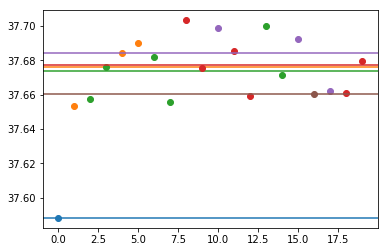

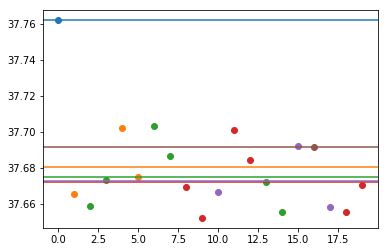

In [328]:
#COEFFMAT[:, 0] = COEFFMAT[:, 0].mean()
#plt.plot(COEFFMAT[:, 3])
#plt.plot(COEFFMAT[:, 0])
#plt.plot(COEFFMAT[:, 4])
def test():
    grid, weight, dens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    print ((weight*dens).sum())
    for atom in range(2):
        ds = 1/np.linalg.norm(grid - c.coordinates[atom], axis=1)
        print ((weight*dens*ds).sum())
#test()
xs = COEFFMAT[:, 1]
for gidx, group in enumerate(((0, ), (1, 4, 5),(6, 7, 2, 3, 13, 14), (8, 9, 18, 19, 11, 12), (10,15,17), (16,))):
    plt.plot(group, xs[list(group)], 'o', color='C%d' % gidx)
    plt.axhline(xs[list(group)].mean(), color='C%d' % gidx)
plt.show()
xs = COEFFMAT[:, 2]
for gidx, group in enumerate(((0, ), (1, 4, 5),(6, 7, 2, 3, 13, 14), (8, 9, 18, 19, 11, 12), (10,15,17), (16,))):
    plt.plot(group, xs[list(group)], 'o', color='C%d' % gidx)
    plt.axhline(xs[list(group)].mean(), color='C%d' % gidx)

## Results

In [48]:
def read_predictions():
    dfs = []
    def atomisation(row):
        atomE = {'5': -23.624308208720, '6': -37.714812342283, '7': -52.831420359950}
        a = row['prediction'] - sum([atomE[_] for _ in row['target']])
        return a
    for bnpairs in range(1, 11):
        df = pd.read_pickle('c20-data/predictions/bnpairs-%d.pkl' % bnpairs)
        df['pairs'] = bnpairs
        df['predictionatom'] = df.apply(atomisation, axis=1)
        dfs.append(df)
        
    return pd.concat(dfs).sort_values('prediction').reset_index()
predictions = read_predictions()

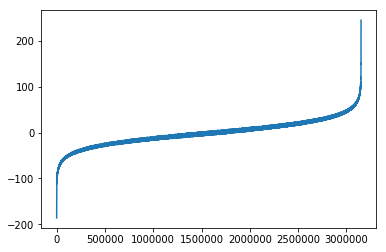

In [49]:
plt.plot(predictions.predictionatom)

In [51]:
def read_CCSD():
    res = []
    atomE = {'5': -24.561351362788, '6': -37.714812342283, '7': -54.418867578066}
    for fn in glob.glob('validation/CCSD/*/run.log'):
        with open(fn) as fh:
            lines = fh.readlines()[::-1]
            for line in lines:
                if line.startswith(' Total CCSD energy [au]:'):
                    energy = float(line.strip().split()[-1])
                    target = fn.split('/')[-2]
                    atomisation = energy - sum([atomE[_] for _ in target])
                    res.append({'target': target, 'CCSD': energy, 'CCSDatom': atomisation})
                    break
    return pd.DataFrame(res)
df_ccsd = read_CCSD()

In [111]:
def read_PBE():
    res = []
    atomE = {'5': -2.606628102620043, '6': -5.303933090334334, '7': -9.70772035021036}
    for fn in glob.glob('validation/PBE/*/run.log'):
        with open(fn) as fh:
            lines = fh.readlines()[::-1]
            for line in lines:
                if 'ENERGY| Total FORCE_EVAL ( QS ) energy (a.u.):' in line:
                    energy = float(line.strip().split()[-1])
                    target = fn.split('/')[-2]
                    try:
                        atomisation = energy - sum([atomE[_] for _ in target])
                    except:
                        break
                    res.append({'target': target, 'PBE': energy, 'PBEatom': atomisation})
                    break
    return pd.DataFrame(res)
df_pbe = read_PBE()

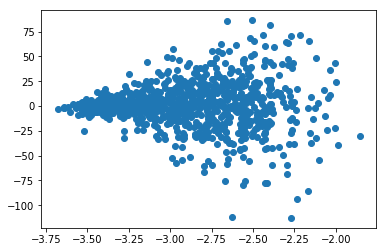

In [143]:
#compare = pd.merge(df_ccsd, predictions, how='inner')
q = 1/10
plt.scatter(compare.CCSDatom, compare.predictionatom-compare.order3 *(1.8)-compare.order2*(2))

In [166]:
comparepbe = pd.merge(df_ccsd, df_pbe, how='inner')
bnpairslookup = predictions['target pairs'.split()]
comparepbe = pd.merge(comparepbe, bnpairslookup, how='inner')
#plt.scatter(compare.CCSDatom, compare.PBEatom)

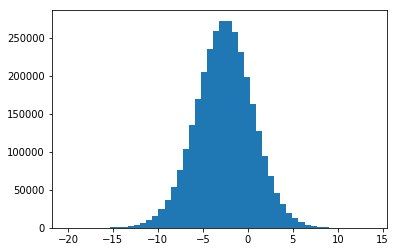

In [74]:
_ = plt.hist(predictions.order2.values, bins=50)

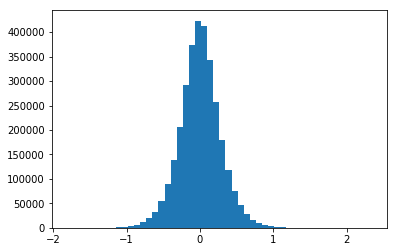

In [77]:
_ = plt.hist(predictions.order3.values/100, bins=50)

In [774]:
def debugcompare():
    ret = []
    for target in compare.target.values[::10]:
        try:
            q = symbolic_get_predictions([int(_) for _ in target])
            q['pairs'] = len([_ for _ in target if _ =='5'])
            ret.append(q)
        except:
            print (target)
            raise
    def atomisation(row):
        atomE = {'5': -23.624308208720, '6': -37.714812342283, '7': -52.831420359950}
        a = sum([atomE[_] for _ in row['target']])
        return a
    df = pd.DataFrame(ret)
    df['predictionatom'] = df.apply(atomisation, axis=1)
    q = pd.merge(df, df_ccsd, how='inner')
    return q
debugdf = debugcompare()
#debugdf

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


In [175]:
compare['erroratom'] = abs(compare.predictionatom - compare.order3 - compare.order2- compare.CCSDatom)
comparepbe['erroratom'] = abs(comparepbe.PBEatom - comparepbe.CCSDatom)

,deltaNN,order0,order1,order2,pairs,prediction,ref,target,predictionatom,CCSD,CCSDatom,erroratom
0,-0.177663,0.0,-9.605145,-122.107931,10,-889.962768,-758.07203,55555555775777777577,-764.557286,-791.867477,-2.065288,1.232264
1,-0.819727,0.0,-8.499879,-26.338954,9,-793.730591,-758.07203,55555557775767775677,-763.531182,-788.567523,-2.315928,1.544527
2,0.874518,0.0,-9.127715,11.185643,9,-755.139584,-758.07203,55555565777677757775,-763.531182,-788.357181,-2.105586,0.688460
3,-1.959021,0.0,-8.264822,-104.587770,9,-872.883643,-758.07203,55555577577767765757,-763.531182,-788.680067,-2.428472,2.336220
4,-0.802402,0.0,-8.458100,-4.897215,9,-772.229746,-758.07203,55556575775776577577,-763.531182,-788.708944,-2.457349,1.344001


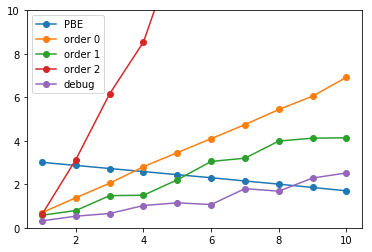

In [783]:
comparepbe['erroratom'] = abs(comparepbe.PBEatom - comparepbe.CCSDatom)
q = comparepbe.groupby('pairs').mean().reset_index()
plt.plot(q.pairs, q.erroratom, 'o-', label='PBE')

compare['erroratom'] = abs(compare.predictionatom - compare.order3 - compare.order2- compare.CCSDatom)
q = compare.groupby('pairs').mean().reset_index()
plt.plot(q.pairs, q.erroratom, 'o-', label='order 0')
compare['erroratom'] = abs(compare.predictionatom - compare.order3 - compare.CCSDatom)
q = compare.groupby('pairs').mean().reset_index()
plt.plot(q.pairs, q.erroratom, 'o-', label='order 1')
compare['erroratom'] = abs(compare.predictionatom- compare.CCSDatom)
q = compare.groupby('pairs').mean().reset_index()
plt.plot(q.pairs, q.erroratom, 'o-', label='order 2')

debugdf['erroratom'] = abs(debugdf.ref -debugdf.predictionatom + debugdf.deltaNN  +debugdf.order0+debugdf.order1+debugdf.order2*0  - debugdf.CCSDatom)
q = debugdf.groupby('pairs').mean().reset_index()
plt.plot(q.pairs, q.erroratom, 'o-', label='debug')



plt.legend()
plt.ylim(0, 10)
debugdf.head()

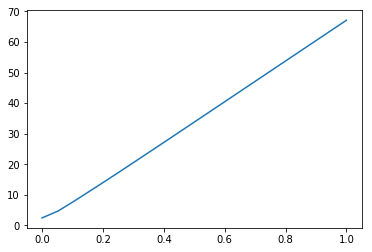

In [657]:
#plt.scatter(debugdf.CCSDatom,debugdf.CCSDatom)
#xs = np.linspace(0.61574,0.61576, 20)
xs = np.linspace(0.,1.0, 20)
ys = [(abs(debugdf.ref -debugdf.predictionatom + debugdf.deltaNN  +debugdf.order0 + debugdf.order1*0.346 - debugdf.order2*_)).mean() for _ in xs]
plt.plot(xs, ys)

In [643]:
#0.38424
#1/(1-0.6040)
np.sqrt(2.6)

1.61245154965971

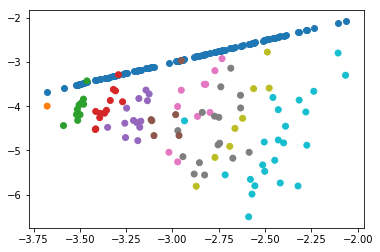

In [784]:
#plt.scatter(comparepbe.CCSDatom, comparepbe.CCSDatom)
#plt.scatter(comparepbe.CCSDatom, comparepbe.PBEatom)
plt.scatter(debugdf.CCSDatom, debugdf.CCSDatom)
plt.scatter(debugdf.CCSDatom, debugdf.ref -debugdf.predictionatom + debugdf.deltaNN  +debugdf.order0 + debugdf.order1, color=['C%d' % min(_, 9) for _ in debugdf.pairs.values])

In [410]:
zs = np.zeros(20)+6
zs[0] = 7
zs[1] = 5
zs[build_reindexing_1_cached(1, 0)]

array([6., 7., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6.])

In [411]:
np.argsort([4, 0, 1, 2, 3, 13, 14, 5, 6, 7, 8, 9, 10, 11, 12, 19, 15, 16, 17, 18])

array([ 1,  2,  3,  4,  0,  7,  8,  9, 10, 11, 12, 13, 14,  5,  6, 16, 17,
       18, 19, 15])

In [578]:
1/1.8892

0.5293245818335803